In [1]:
!python -V

Python 3.9.24


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
import pickle
import mlflow
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/10/24 12:51:35 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/10/24 12:51:35 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1761241360745, experiment_id='1', last_update_time=1761241360745, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
def read_dataframe(filename):
    
    df = pd.read_parquet(filename)

    # Calculate trip duration in minutes

    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60) 

    # Keep only trips that at least 1 minute and at most 60

    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

    # Reduce dataset for perfomance. The model won't require so many data points

    df_sample = df.sample(frac=0.1, random_state=2)
    df_sample.shape

    # Features for modeling

    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']

    df_sample[categorical] = df_sample[categorical].astype(str)
    
    df_sample['PU_DO'] = df_sample['PULocationID'] + "_" + df_sample['DOLocationID']
    
    return df_sample

In [4]:
# df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet")
# df_val = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet")

df_train = pd.read_parquet("./data/yellow_tripdata_2024-01.parquet")
df_val = pd.read_parquet("./data/yellow_tripdata_2024-02.parquet")

In [5]:
len(df_train), len(df_val)

(289891, 293806)

In [ ]:
categorical = ['PU_DO'] # ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

RMSE 5.6840807557703


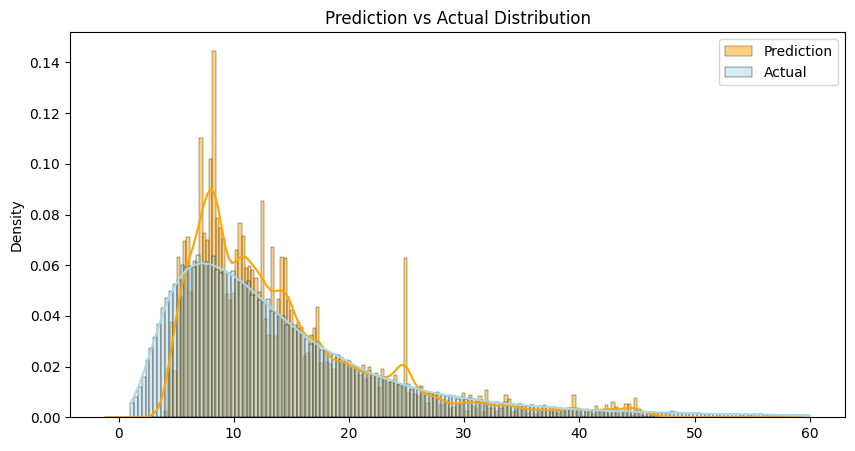

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

print("RMSE", root_mean_squared_error(y_val, y_pred, ))

plt.figure(figsize=(10,5))

sns.histplot(y_pred, color='orange', label='Prediction', kde=True, stat='density', alpha=0.5)
sns.histplot(y_train, color='lightblue', label='Actual', kde=True, stat='density', alpha=0.5)

plt.legend()
plt.title("Prediction vs Actual Distribution")
plt.show()

In [7]:
with mlflow.start_run():

    mlflow.set_tag("developer", "diogo")

    mlflow.log_param("traning-data-path", "./data/yellow_tripdata_2024-01.parquet")
    mlflow.log_param("val-data-path", "./data/yellow_tripdata_2024-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr_lasso = Lasso(alpha=alpha)
    lr_lasso.fit(X_train, y_train)

    y_pred = lr_lasso.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open(f'models/lin_reg_lasso_{alpha}.bin', 'wb') as f_out:
        pickle.dump((dv, lr_lasso), f_out)

    mlflow.log_artifact(local_path=f'models/lin_reg_lasso_{alpha}.bin', artifact_path='pickle_models')



In [20]:
lr_ridge = Ridge(alpha=0.01)
lr_ridge.fit(X_train, y_train)

y_pred = lr_ridge.predict(X_val)

print("RMSE", mean_squared_error(y_val, y_pred, squared=False))

RMSE 6.037936024543055


In [24]:
# Save model

with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [10]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [ ]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=10,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

        return {"loss": rmse, "status": STATUS_OK}

In [ ]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": "reg:linear",
    "seed": 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=Trials())

In [13]:
with mlflow.start_run(run_name="best xgboost with preprocessor"):

    best_params = {
    "max_depth": 54,
    "learning_rate": 0.838560298111564,
    "reg_alpha": 0.07217623016548881,
    "reg_lambda": 0.0038449610359954913,
    "min_child_weight": 9.039435151170704,
    "objective": "reg:linear",
    "seed": 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
    params=best_params,
    dtrain=train,
    num_boost_round=10,
    evals=[(valid, "validation")],
    early_stopping_rounds=50)

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:21:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:5.61749
[1]	validation-rmse:5.34707
[2]	validation-rmse:5.30852
[3]	validation-rmse:5.29391
[4]	validation-rmse:5.28724
[5]	validation-rmse:5.28285
[6]	validation-rmse:5.27766
[7]	validation-rmse:5.27338
[8]	validation-rmse:5.26896
[9]	validation-rmse:5.26424


2025/10/24 13:21:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:21:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/10/24 13:21:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
# Making prediction with a logged model

logged_model = 'runs:/6d45753a75544988989ab211cb6bd026/models_mlflow'

loaded_model = mlflow.pyfunc.load_model(logged_model)

In [17]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: /workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/models/m-1389733a56af4cad8dc6139c007d5fea/artifacts
  flavor: mlflow.xgboost
  run_id: 6d45753a75544988989ab211cb6bd026

In [ ]:
# Same as a xgboost object

xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model 

In [19]:
y_pred = xgboost_model.predict(valid)

In [20]:
y_pred[:10]

array([ 6.035171 , 10.910734 , 12.311847 , 17.939478 , 15.171875 ,
       10.3225155,  9.594873 , 10.926294 ,  9.158309 ,  4.929315 ],
      dtype=float32)